# Aula 13 - Processamento de Linguagem Natural

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Exercício e revisão da aula passada
- 2) Pré-processamento usando Word2Vec
- 3) Exercícios de NLP

In [ ]:
import re

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer

In [ ]:
tweets = pd.read_csv('./datasets/tweets.csv', index_col=0)

In [ ]:
tweets.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [ ]:
tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Pipeline - Text Preprocessing
def preprocessing(string, stemmer, stopwords=nltk.corpus.stopwords.words('english')):
    ###
    # Remove Numbers
    string = re.sub(r'\d', '', string)
    ###
    # Remove Special Characters
    string = re.sub(r"[^a-zA-Z0-9]+", ' ', string)
    ###
    # Lowercase words
    string = string.lower()
    ###
    # Word Tokenize
    words = word_tokenize(string)
    ###
    # Remove Stopwords
    filtered_words = []
    for w in words:
        if w not in stopwords:
            filtered_words.append(w)
    ###
    # Stemming Words
    stem_words = []
    for w in filtered_words:
        s_words = stemmer.stem(w)
        stem_words.append(s_words)
    ###
    return stem_words

In [ ]:
# Stemmer
stemmer = PorterStemmer()

# Preprocessando o texto

tweets["filtered_words"] = tweets['text'].apply(lambda x: preprocessing(x, stemmer))

# Normalmente depois do processamento juntamos as palavras novamente em uma só string

tweets['join_words'] = tweets['filtered_words'].apply(lambda x: ' '.join(x))

In [ ]:
tweets.iloc[3]['text']

'13,000 people receive #wildfires evacuation orders in California '

In [ ]:
tweets.iloc[3]['join_words']

'peopl receiv wildfir evacu order california'

In [ ]:
tweets.iloc[5]['join_words']

'rockyfir updat california hwi close direct due lake counti fire cafir wildfir'

In [ ]:
X = tweets['join_words']
y = tweets['target']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                     y, 
                                                     test_size = 0.3, 
                                                     random_state = 42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

counter = CountVectorizer()
tfidf = TfidfVectorizer(use_idf = True)

In [ ]:
X_train_bow = counter.fit_transform(X_train).toarray()
X_test_bow = counter.transform(X_test).toarray()

In [ ]:
type(X_train_bow)

numpy.ndarray

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf  = tfidf.transform(X_test).toarray()

In [ ]:
X_train_bow.shape

(5329, 13803)

In [ ]:
X_train_tfidf.shape

(5329, 13803)

In [ ]:
type(X_train_tfidf)

numpy.ndarray

In [ ]:
# Matrizes esparsas: Matrizes com a maioria dos valores zero
type(tfidf.fit_transform(X_train))

In [ ]:
# Matrizes esparsas -> numpy.matrix
type(tfidf.fit_transform(X_train).todense())

In [ ]:
# Matrizes esparsas -> numpy.ndarray
type(tfidf.fit_transform(X_train).toarray())

In [ ]:
random_seed = 42

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

list_models_bow = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, 
                                  solver = 'lbfgs')},
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)}, 
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state = random_seed)}
]

list_models_tfidf = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, 
                                  solver = 'lbfgs')},
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)}, 
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state = random_seed)}
]

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def test_models_plot_roc_auc_curve(model_list, col_model_name, col_model, X_train, X_test, y_train, y_test):
    for mdl in model_list:
        model = mdl[col_model]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc = metrics.roc_auc_score(y_test, model.predict(X_test))
        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (mdl[col_model_name], auc))
        print("Model      : %s" % mdl[col_model_name])
        print("Accuracy   : %0.4f " %  accuracy_score(y_test, y_predict))
        print("Precision  : %0.4f " % precision_score(y_test, y_predict, average='weighted'))
        print("Recall     : %0.4f " % recall_score(y_test, y_predict, average='weighted'))
        print("F1 - Score : %0.4f " % f1_score(y_test, y_predict, average='weighted'))
        print("ROC - AUC  : %0.4f " % auc)
        print("======================")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC curve')
    plt.legend(loc="lower right")
    plt.show()

Model      : Logistic Regression
Accuracy   : 0.8004 
Precision  : 0.8006 
Recall     : 0.8004 
F1 - Score : 0.7980 
ROC - AUC  : 0.7869 
Model      : Decision Tree
Accuracy   : 0.7482 
Precision  : 0.7470 
Recall     : 0.7482 
F1 - Score : 0.7473 
ROC - AUC  : 0.7387 
Model      : Random Forest
Accuracy   : 0.7986 
Precision  : 0.8075 
Recall     : 0.7986 
F1 - Score : 0.7923 
ROC - AUC  : 0.7763 
Model      : AdaBoost
Accuracy   : 0.7500 
Precision  : 0.7558 
Recall     : 0.7500 
F1 - Score : 0.7413 
ROC - AUC  : 0.7252 


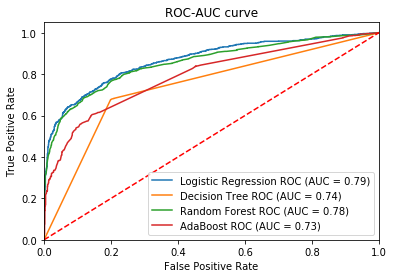

In [ ]:
test_models_plot_roc_auc_curve(list_models_bow,
                               "model_name",
                               "estimator",
                               X_train_bow,
                               X_test_bow,
                               y_train,
                               y_test)

Model      : Logistic Regression
Accuracy   : 0.8012 
Precision  : 0.8013 
Recall     : 0.8012 
F1 - Score : 0.7990 
ROC - AUC  : 0.7881 
Model      : Decision Tree
Accuracy   : 0.7180 
Precision  : 0.7170 
Recall     : 0.7180 
F1 - Score : 0.7174 
ROC - AUC  : 0.7090 
Model      : Random Forest
Accuracy   : 0.7964 
Precision  : 0.8007 
Recall     : 0.7964 
F1 - Score : 0.7917 
ROC - AUC  : 0.7774 
Model      : AdaBoost
Accuracy   : 0.7461 
Precision  : 0.7498 
Recall     : 0.7461 
F1 - Score : 0.7382 
ROC - AUC  : 0.7226 


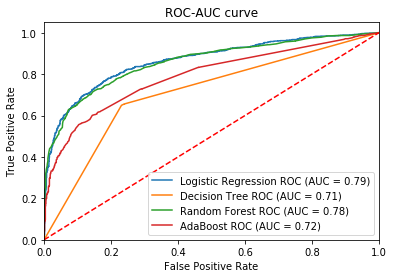

In [ ]:
test_models_plot_roc_auc_curve(list_models_tfidf,
                               "model_name",
                               "estimator",
                               X_train_tfidf,
                               X_test_tfidf,
                               y_train,
                               y_test)

---

---

# Revisando pré-processamento de texto

In [ ]:
import re

import numpy as np
import pandas as pd
from unidecode import unidecode

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer

In [ ]:
tweets.head()

,keyword,location,text,target,filtered_words,join_words
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquak, may, allah, forgiv, us]",deed reason earthquak may allah forgiv us
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, rong, sask, canada]",forest fire near la rong sask canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[resid, ask, shelter, place, notifi, offic, ev...",resid ask shelter place notifi offic evacu she...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[peopl, receiv, wildfir, evacu, order, califor...",peopl receiv wildfir evacu order california
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, rubi, alaska, smoke, wildfi...",got sent photo rubi alaska smoke wildfir pour ...


In [ ]:
textos = list(tweets.head().loc[:,'text'].values)

In [ ]:
for frase in textos:
    print(frase)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


# Tratamento de Texto

## Funções de Strings

In [ ]:
textos[3]

'13,000 people receive #wildfires evacuation orders in California '

In [ ]:
frase = "13.000 pessoas receberam ordens de evacuação por #incêndios na Califórnia"

In [ ]:
frase.upper()

'13.000 PESSOAS RECEBERAM ORDENS DE EVACUAÇÃO POR #INCÊNDIOS NA CALIFÓRNIA'

In [ ]:
frase.lower()

'13.000 pessoas receberam ordens de evacuação por #incêndios na califórnia'

In [ ]:
frase_decode = unidecode(frase.lower())
print(frase_decode)

13.000 pessoas receberam ordens de evacuacao por #incendios na california


In [ ]:
frase.split()

['13.000',
 'pessoas',
 'receberam',
 'ordens',
 'de',
 'evacuação',
 'por',
 '#incêndios',
 'na',
 'Califórnia']

In [ ]:
"oi, como vai?".split()

['oi,', 'como', 'vai?']

In [ ]:
'/'.join(['data', 'trabalhos', 'repositorio'])

'data/trabalhos/repositorio'

## Regex

In [ ]:
frase_decode

'13.000 pessoas receberam ordens de evacuacao por #incendios na california'

In [ ]:
re.search(r'\d', frase_decode)

<re.Match object; span=(0, 1), match='1'>

In [ ]:
re.findall(r'\d', frase_decode)

['1', '3', '0', '0', '0']

In [ ]:
re.findall(r'\d+', frase_decode)

['13', '000']

In [ ]:
sub_first = re.sub(r'\d', '', frase_decode)
print(sub_first)

. pessoas receberam ordens de evacuacao por #incendios na california


In [ ]:
re.search(r'[^a-zA-Z0-9]+', sub_first)

<re.Match object; span=(0, 2), match='. '>

In [ ]:
re.findall(r'[a-zA-Z0-9]+', sub_first)

['pessoas',
 'receberam',
 'ordens',
 'de',
 'evacuacao',
 'por',
 'incendios',
 'na',
 'california']

In [ ]:
re.findall(r'[^a-zA-Z0-9 ]+', sub_first)

['.', '#']

In [ ]:
sub_second = re.sub(r"[^a-zA-Z0-9]+", ' ', sub_first)
print(sub_second)

 pessoas receberam ordens de evacuacao por incendios na california


## Tokenização

In [ ]:
tokens = nltk.word_tokenize(sub_second)

In [ ]:
print(tokens)

['pessoas', 'receberam', 'ordens', 'de', 'evacuacao', 'por', 'incendios', 'na', 'california']


## N-grams

In [ ]:
tokens

['pessoas',
 'receberam',
 'ordens',
 'de',
 'evacuacao',
 'por',
 'incendios',
 'na',
 'california']

In [ ]:
print(list(nltk.bigrams(tokens)))

[('pessoas', 'receberam'), ('receberam', 'ordens'), ('ordens', 'de'), ('de', 'evacuacao'), ('evacuacao', 'por'), ('por', 'incendios'), ('incendios', 'na'), ('na', 'california')]


In [ ]:
print(list(nltk.trigrams(tokens)))

[('pessoas', 'receberam', 'ordens'), ('receberam', 'ordens', 'de'), ('ordens', 'de', 'evacuacao'), ('de', 'evacuacao', 'por'), ('evacuacao', 'por', 'incendios'), ('por', 'incendios', 'na'), ('incendios', 'na', 'california')]


## Stopwords 

In [ ]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [ ]:
print(stopwords)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [ ]:
tokens = [word for word in tokens if word not in stopwords]
print(tokens)

['pessoas', 'receberam', 'ordens', 'evacuacao', 'incendios', 'california']


## Normalização de Texto
### Stemming e Lemmatization

In [ ]:
# Stemmer
stemmer = PorterStemmer()
print([stemmer.stem(w) for w in tokens])

#Lemmatization
lemmatizer = WordNetLemmatizer()
print([lemmatizer.lemmatize(w) for w in tokens])

['pessoa', 'receberam', 'orden', 'evacuacao', 'incendio', 'california']
['pessoas', 'receberam', 'ordens', 'evacuacao', 'incendios', 'california']


---
Sobre lematização na Língua Portuguesa:

Biblioteca Spacy

In [ ]:
#!pip install spacy

In [ ]:
#!python -m spacy download pt_core_news_lg
#!python -m spacy download pt_core_news_md
#!python -m spacy download pt_core_news_sm

In [ ]:
print(frase)

13.000 pessoas receberam ordens de evacuação por #incêndios na Califórnia


In [ ]:
import spacy

# Carregamos o modelo de língua que baixamos
nlp = spacy.load("pt_core_news_lg")

In [ ]:
type(nlp)

spacy.lang.pt.Portuguese

In [ ]:
# Usamos o modelo para analisar o nosso texto :)
doc = nlp(frase)

In [ ]:
type(doc)

spacy.tokens.doc.Doc

In [ ]:
print([token for token in doc])

[13.000, pessoas, receberam, ordens, de, evacuação, por, #, incêndios, na, Califórnia]


In [ ]:
lista = []
for token in doc:
    lista.append(token)
    
print(lista)

[13.000, pessoas, receberam, ordens, de, evacuação, por, #, incêndios, na, Califórnia]


In [ ]:
print([type(token) for token in doc])

[<class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>, <class 'spacy.tokens.token.Token'>]


In [ ]:
print([token.orth_ for token in doc])

['13.000', 'pessoas', 'receberam', 'ordens', 'de', 'evacuação', 'por', '#', 'incêndios', 'na', 'Califórnia']


Comparando o lematizador do Spacy com o WordNet

In [ ]:
print([token.lemma_ for token in doc])

['13.000', 'pessoa', 'receber', 'ordem', 'de', 'evacuação', 'por', '#', 'incêndio', 'o', 'Califórnia']


In [ ]:
print([lemmatizer.lemmatize(token.orth_) for token in doc])

['13.000', 'pessoas', 'receberam', 'ordens', 'de', 'evacuação', 'por', '#', 'incêndios', 'na', 'Califórnia']


# Repetindo em inglês

In [ ]:
frase_en = textos[3]
print(frase_en)

13,000 people receive #wildfires evacuation orders in California 


In [ ]:
frase_en = frase_en.lower()
frase_en = re.sub(r'\d', '', frase_en)
frase_en = re.sub(r"[^a-zA-Z0-9]+", ' ', frase_en)
tokens_en = nltk.word_tokenize(frase_en)

In [ ]:
# Stemmer
stemmer = PorterStemmer()
print([stemmer.stem(w) for w in tokens_en])

#Lemmatization
lemmatizer = WordNetLemmatizer()
print([lemmatizer.lemmatize(w) for w in tokens_en])

['peopl', 'receiv', 'wildfir', 'evacu', 'order', 'in', 'california']
['people', 'receive', 'wildfire', 'evacuation', 'order', 'in', 'california']
